In [1]:
import pandas as pd
import tiktoken
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import preprocessing as pp 

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nicolas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nicolas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/nicolas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nicolas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nicolas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nicolas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
DATA_PATH = '../../data/'
filename = 'english_cleaned_lyrics.csv'
zipfile = 'english_cleaned_lyrics.zip'


In [3]:
df = pd.read_csv(DATA_PATH + filename)
df

,Unnamed: 0,index,song,year,artist,genre,lyrics
0,0,0,ego-remix,2009,beyonce-knowles,Pop,Oh baby how you doing You know I'm gonna cut r...
1,1,1,then-tell-me,2009,beyonce-knowles,Pop,playin everything so easy it's like you seem s...
2,2,2,honesty,2009,beyonce-knowles,Pop,If you search For tenderness It isn't hard to ...
3,3,3,you-are-my-rock,2009,beyonce-knowles,Pop,Oh oh oh I oh oh oh I If I wrote a book about ...
4,4,4,black-culture,2009,beyonce-knowles,Pop,Party the people the people the party it's pop...
...,...,...,...,...,...,...,...
218205,362232,362232,who-am-i-drinking-tonight,2012,edens-edge,Country,I gotta say Boy after only just a couple of da...
218206,362233,362233,liar,2012,edens-edge,Country,I helped you find her diamond ring You made me...
218207,362234,362234,last-supper,2012,edens-edge,Country,Look at the couple in the corner booth Looks a...
218208,362235,362235,christ-alone-live-in-studio,2012,edens-edge,Country,When I fly off this mortal earth And I'm measu...


In [4]:
print('   -------------------')
print("Number of artists:", len(df['artist'].unique()))
print('   -------------------')
print("Genres:", df['genre'].unique())
print('   -------------------')
years = df['year'].unique()
years.sort()
print("years:", years)
print('   -------------------')

   -------------------
Number of artists: 10431
   -------------------
Genres: ['Pop' 'Hip-Hop' 'Rock' 'Metal' 'Other' 'Country' 'Jazz' 'Electronic'
 'Folk' 'R&B' 'Indie']
   -------------------
years: [  67  112  702 1968 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979
 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993
 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010 2011 2012 2013 2014 2015 2016]
   -------------------


In [5]:
df = df[~(df['genre'] == 'Other')]

In [6]:
df[(df['year'] == 67) | (df['year'] == 112) | (df['year'] == 702)]


,Unnamed: 0,index,song,year,artist,genre,lyrics
15554,27657,27657,star,702,clipse,Hip-Hop,You're my star It's such a wonder how you shin...
40894,69708,69708,anywhere-remix,112,dru-hill,Hip-Hop,Here we are all alone You and me privacy And w...
88365,147914,147914,it-s-over-now-remix,112,g-dep,Hip-Hop,What is this Numbers in your pocket I remember...
143439,238541,238541,come-see-me-remix,112,black-rob,Hip-Hop,Baby you can come see me cause I need you here...
190373,315540,315540,let-s-lurk,67,giggs,Hip-Hop,Verse 1 Still pulling up on smoke Skeng in my ...
201649,335205,335205,i-can-t-believe,112,faith-evans,Pop,I can't believe that love has gone away from ...


## Testing byte pair encoding with tiktoken on 1 sample

In [ ]:
lyric = df['lyrics'][0]
preprocessed_lyric = lyric.lower()
preprocessed_lyric = ''.join(char for char in lyric if char not in string.punctuation)

stop_words = set(stopwords.words('english'))
filtered_lyric = [word for word in preprocessed_lyric.split() if word not in stop_words]
preprocessed_lyric = ' '.join(filtered_lyric)
print(f"lyrics before preprocessing {len(lyric)} words:", lyric)
print(f"lyrics after preprocessing {len(preprocessed_lyric)} words:", preprocessed_lyric)

In [ ]:
def compare_encodings(example_string: str) -> None:
    """Prints a comparison of three string encodings."""
    # print the example string
    print(f'\nExample string: "{example_string}"')
    # for each encoding, print the # of tokens, the token integers, and the token bytes
    for encoding_name in ["r50k_base", "p50k_base", "cl100k_base", "gpt-4"]:
        if encoding_name == "gpt-4":
            encoding = tiktoken.encoding_for_model("gpt-4")
        else:
            encoding = tiktoken.get_encoding(encoding_name)

        token_integers = encoding.encode(example_string)
        num_tokens = len(token_integers)
        token_bytes = [encoding.decode_single_token_bytes(token) for token in token_integers]
        print()
        print(f"{encoding_name}: {num_tokens} tokens")
        print(f"token integers: {token_integers}")
        print(f"token bytes: {token_bytes}")

In [ ]:
compare_encodings(lyric)

In [ ]:
compare_encodings(df['lyrics'][2])

In [ ]:
df[df['genre'] == 'Electronic']

In [ ]:
df = df[['artist', 'genre', 'year', 'lyrics', 'lyrics-preprocessed', 'byte-pair-encoding']]
df.to_csv(DATA_PATH + 'lyrics-preprocessed.csv', index=False)

# Plot Distribution

<Axes: title={'center': 'Number of songs per genre'}, xlabel='genre'>

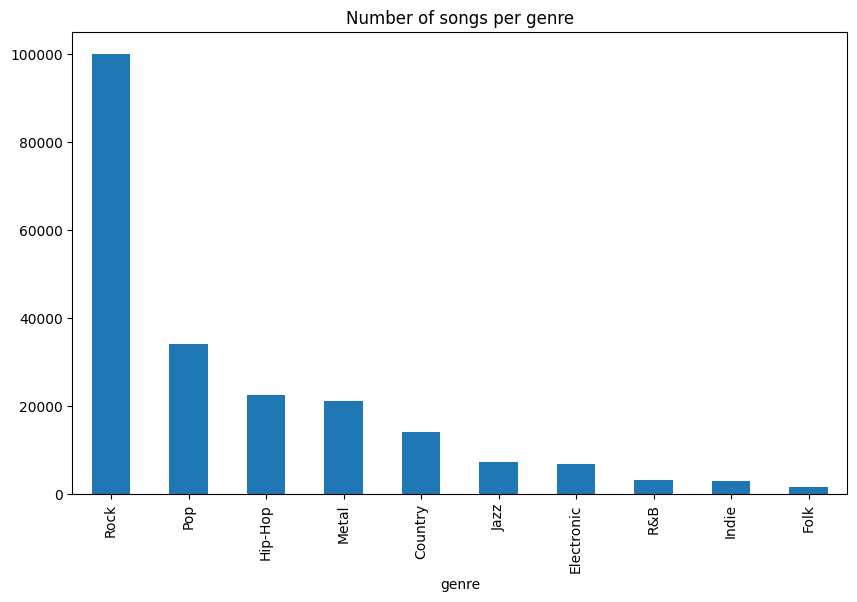

In [7]:
# plot histogram of music genres
df['genre'].value_counts().plot(kind='bar', figsize=(10, 6), title='Number of songs per genre')

In [8]:
df[df['genre'] == 'Pop'].value_counts()

Unnamed: 0  index   song              year  artist           genre  lyrics                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

# Splitting years

In [9]:
df1, df2, df3, df4 = pp.split_years(df)
# df1.plot(kind='bar', figsize=(10, 6), title='Number of songs per genre in 1960-1979')
# df2.plot(kind='bar', figsize=(10, 6), title='Number of songs per genre in 1980-1999')
# df3.plot(kind='bar', figsize=(10, 6), title='Number of songs per genre in 2000-2019')
# df4.plot(kind='bar', figsize=(10, 6), title='Number of songs per genre in 2020-2021')



/home/nicolas/Prog/python-projects/NLP/nlp-project/src/preprocessing/preprocessing.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['interval'] = pd.cut(df['year'], bins=bins, labels=labels, right=True)


<Axes: title={'center': 'Number of songs per genre in 1960-1979'}, xlabel='genre'>

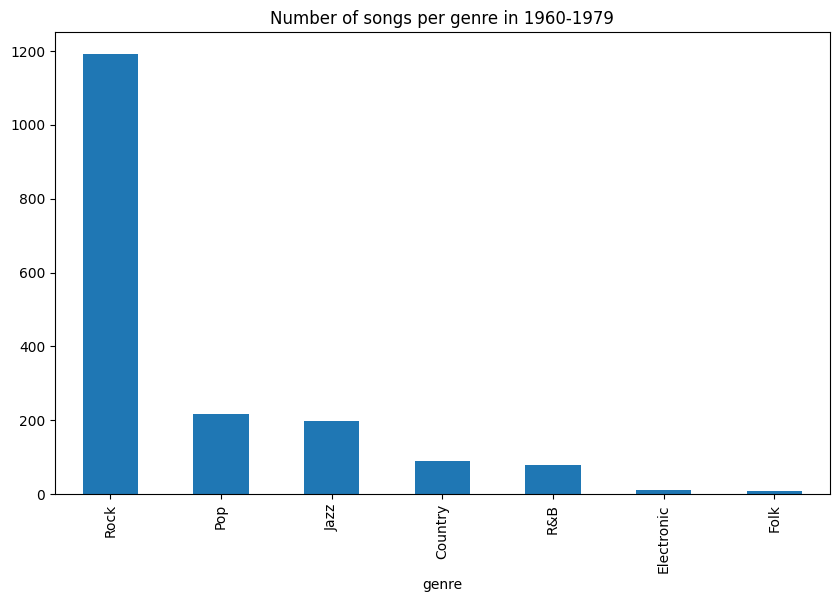

In [14]:
df1['genre'].value_counts().plot(kind='bar', figsize=(10, 6), title='Number of songs per genre in 1960-1979')

<Axes: title={'center': 'Number of songs per genre in 1980-1999'}, xlabel='genre'>

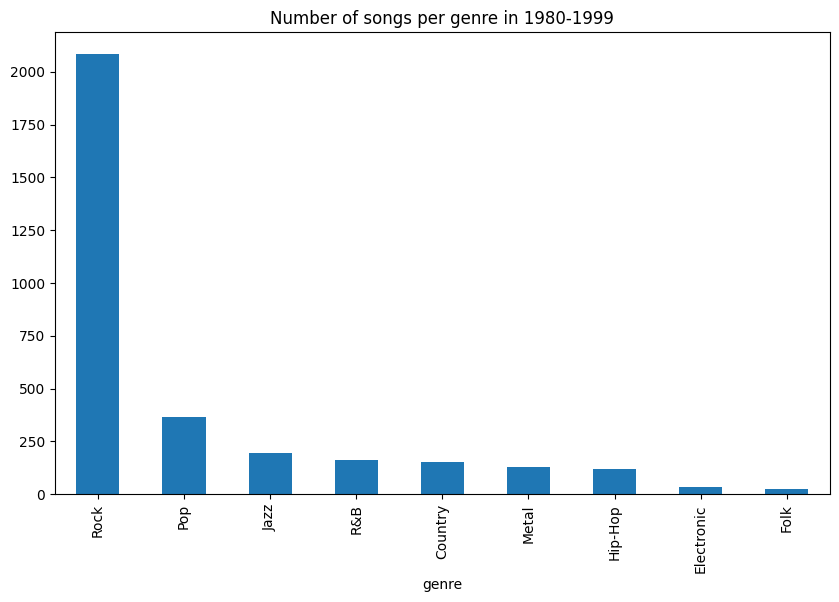

In [15]:
df2['genre'].value_counts().plot(kind='bar', figsize=(10, 6), title='Number of songs per genre in 1980-1999')

<Axes: title={'center': 'Number of songs per genre in 2000-2019'}, xlabel='genre'>

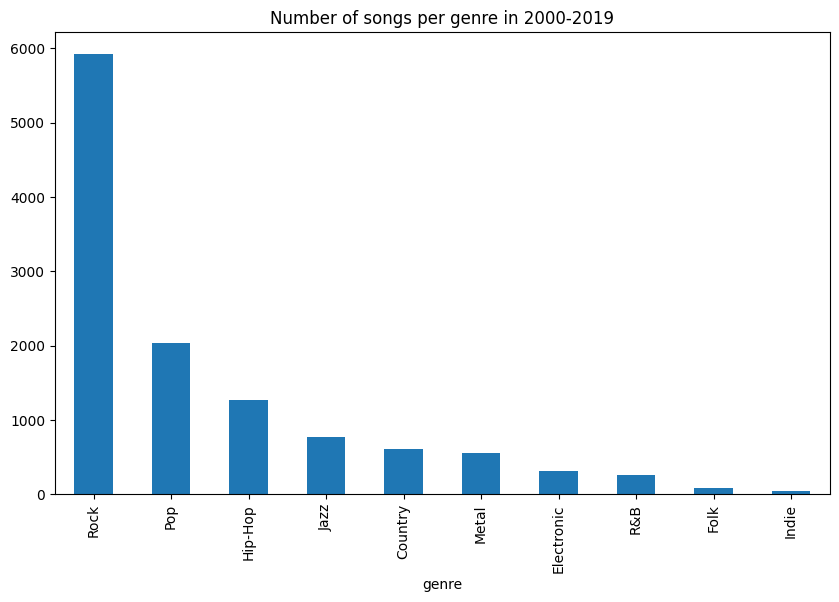

In [16]:
df3['genre'].value_counts().plot(kind='bar', figsize=(10, 6), title='Number of songs per genre in 2000-2019')

<Axes: title={'center': 'Number of songs per genre in 2020-2021'}, xlabel='genre'>

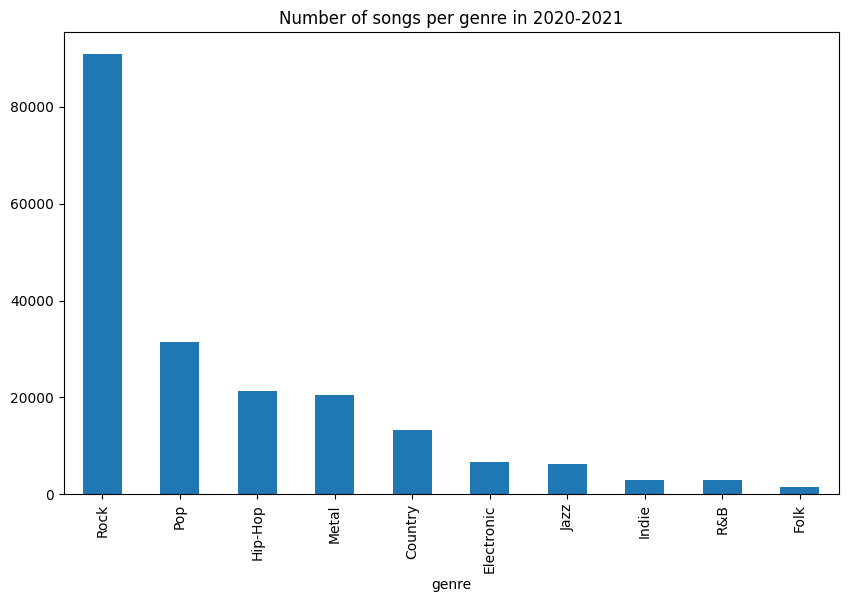

In [17]:
df4['genre'].value_counts().plot(kind='bar', figsize=(10, 6), title='Number of songs per genre in 2020-2021')

# Adjusting genre distribution

In [ ]:
def map_genre_to_category(genre):
    if genre in ['Hip-Hop', 'R&B', 'Electronic']:
        return 'R&B/Hip-Hop/Electronic'
    elif genre in ['Country', 'Folk']:
        return 'Country/Folk'
    else:
        return genre

In [ ]:
df['genre'] = df['genre'].apply(map_genre_to_category)
df['genre'].value_counts().plot(kind='bar', figsize=(10, 6), title='Number of songs per genre group')
display(df)

In [ ]:
# Too many rocks songs, let's reduce the number of rock songs
df = df[~(df['genre'] == 'Other')]
df = df[~(df['genre'] == 'Indie')]

rocks_indices = df[df['genre'] == 'Rock'].index

num_rocks_to_keep = 35000
num_rocks_current = len(rocks_indices)

print(num_rocks_current, num_rocks_to_keep)

if num_rocks_current > num_rocks_to_keep:
    keep_indices = np.random.choice(rocks_indices, num_rocks_to_keep, replace=False)
else:
    keep_indices = rocks_indices

df = df.drop(index=set(rocks_indices) - set(keep_indices))

plt.figure(figsize=(10, 6))
sns.countplot(x='genre', data=df)

plt.title('Distribution of genres') 
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()